In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cv
import time
import gurobipy as gp
from gurobipy import GRB
import scipy

In [2]:
rng = np.random.default_rng(5438)

# Independent Birth Death's with regulation

As a simplification of the 'independent telegraphs with regulation' model, we consider the system:

$ \varnothing \stackrel{k_{1, tx}}\longrightarrow X_{1}  \quad\quad \varnothing \stackrel{k_{2, tx}}\longrightarrow X_{2} $

$ X_{1} \stackrel{k_{1, deg}}\longrightarrow  \varnothing \quad\quad X_{2} \stackrel{k_{2, deg}}\longrightarrow \varnothing $

$ X_{1} + X_{2} \stackrel{k_{reg}}\longrightarrow \varnothing $

with the state space $(x_{1}, x_{2}) \in \mathbb{N} \times \mathbb{N} $

## Simulation

Use gillespie / SSA to simulate sample paths of the reaction

In [69]:
def simulation(params, n, tmax, ts, plot=False, initial_state=(0, 0)):
    '''
    Simulate a sample path of the birth death regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2 = path[-1][0], path[-1][1]

        # transition rates
        q_tx_1 = params['k_tx_1']
        q_tx_2 = params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_tx_1 + q_tx_2 + q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5]
        prob = [
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1 + 1, x2))
            case 2:
                path.append((x1, x2 + 1))
            case 3:
                path.append((x1 - 1, x2))
            case 4:
                path.append((x1, x2 - 1))
            case 5:
                path.append((x1 - 1, x2 - 1))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)
    samples = [(int(x1_samples[i]), int(x2_samples[i])) for i in range(n)]

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("# molcules")
        plt.legend()
        plt.show()

    return samples

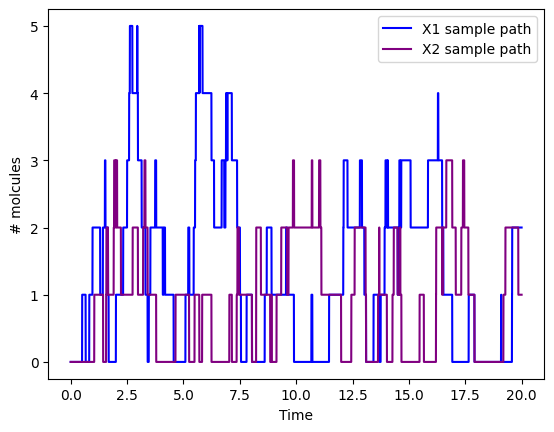

In [5]:
params = {
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}
samples = simulation(params, 2, 10, 10, plot=True)

## Bootstrap

Produce 95% confidence intervals on the stationary probabilities $p(x_{1}, x_{2})$ for the states observed in the sample

In [6]:
def bootstrap(params, n, B, tmax=100, ts=10, thresh=1, plot=False, printing=False, initial_state=(0, 0)):
    '''
    Compute bootstrap confidence intervals on stationary distribution by 
    simulating sample path and computing empirical distribution over 
    several bootstrap samples

    params: dict of reaction rate constants
    n: number of samples from stationary distribution
    B: number of bootstrap resamples
    tmax: burn-in time for sampling
    ts: time between samples
    thresh: minimum occurnces of a state in the original sample to use the CI
        otherwise replaced by [0, 1] bounds
    plot: toggle plotting CI's
    printing: toggle printing CI's
    initial_state: starting point of sampling
    '''
    # simulate n samples from stationary distribution
    samples = simulation(params, n, tmax, ts, plot=False, initial_state=initial_state)

    # compute maximum x1 and x2 values
    M = np.max([sample[0] for sample in samples])
    N = np.max([sample[1] for sample in samples])

    # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
    integer_samples = [sample[1] + (N + 1)*sample[0] for sample in samples]

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # B bootstrap samples as B x n array
    bootstrap = rng.choice(integer_samples, size=(B, n))

    # offset row i by (D + 1)i
    bootstrap_offset = bootstrap + np.arange(B)[:, None]*(D + 1)

    # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
    counts = np.bincount(bootstrap_offset.ravel(), minlength=B*(D + 1)).reshape(-1, M + 1, N + 1)

    # counts to probability
    counts = counts / n

    # sum over columns / rows to give counts of each x1 / x2 state
    x1_counts = counts.sum(axis=2)
    x2_counts = counts.sum(axis=1)

    # compute 2.5% and 97.5% quantiles for each p(x1, x2), p(x1) and p(x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_samples, minlength=D + 1).reshape(M + 1, N + 1)

    # sum over columns / rows to give counts per x1 / x2 state
    x1_sample_counts = sample_counts.sum(axis=1)
    x2_sample_counts = sample_counts.sum(axis=0)

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            if sample_counts[x1, x2] < thresh:
                bounds[:, x1, x2] = [0.0, 1.0]

    for x1 in range(M + 1):
        if x1_sample_counts[x1] < thresh:
            x1_bounds[:, x1] = [0.0, 1.0]

    for x2 in range(N + 1):
        if x2_sample_counts[x2] < thresh:
            x2_bounds[:, x2] = [0.0, 1.0]

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                axs[x1, x2].hist(counts[:, x1, x2])
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color="red")
                axs[x1, x2].axvline(bounds[1, x1, x2], color="red")

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M + 1, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M + 1):
            axs[x1].hist(x1_counts[:, x1])
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color="red")
            axs[x1].axvline(x1_bounds[1, x1], color="red")

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N + 1, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N + 1):
            axs[x2].hist(x2_counts[:, x2])
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color="red")
            axs[x2].axvline(x2_bounds[1, x2], color="red")

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    return {'joint': bounds, 'x1': x1_bounds, 'x2': x2_bounds}

In [20]:
def bootstrap_old(params, n, B, tmax=100, ts=10, thresh=1, plot=False, printing=False, initial_state=(0, 0)):
    '''
    Compute bootstrap confidence intervals on the stationary distribution of system
    Simulate sample path and compute empirical distribution over each bootstrap sample

    params: dict of reaction rate constants
    n: number of samples from the stationary distribution
    B: number of bootstrap resamples
    tmax: burn-in time for sampling
    ts: time between samples
    thresh: minimum threshold of occurances of a state in the original sample for CI bounds to be used
         otherwise bounds are replaced by [0, 1]
    plot: toggle plotting CI's
    printing: toggle printing CI's
    initial_state: starting point of sampling
    '''

    rng = np.random.default_rng(5438)

    # n samples from stationary distribution
    samples = simulation(params, n, tmax, ts, plot=False, initial_state=initial_state)

    # separate x1 and x2 values (always considered paired, but for computational reasons)
    x1_samples = [sample[0] for sample in samples]
    x2_samples = [sample[1] for sample in samples]

    # maximum values found (+ 1)
    M = np.max(x1_samples) + 1
    N = np.max(x2_samples) + 1

    # array to count occurances per state in original sample
    sample_counts = np.zeros((M, N))
    x1_sample_counts = np.zeros(M)
    x2_sample_counts = np.zeros(N)

    # loop over original sample and add to counts
    for i in range(n):
        x1, x2 = samples[i]
        sample_counts[x1, x2] += 1
        x1_sample_counts[x1] += 1
        x2_sample_counts[x2] += 1

    # array to count occurances per state per bootstrap sample
    counts = np.zeros((B, M, N))
    x1_counts = np.zeros((B, M))
    x2_counts = np.zeros((B, N))

    # B bootstrap samples of size n in B x n array
    boot = rng.choice(samples, size=(B, n))

    # loop over each sample (row) and add to counts
    for b in range(B):
        for i in range(n):
            x1, x2 = boot[b, i]
            counts[b, x1, x2] += 1
            x1_counts[b, x1] += 1
            x2_counts[b, x2] += 1

    # normalize counts to probabilities
    counts /= n
    x1_counts /= n
    x2_counts /= n

    # take 2.5%, 97.5% percentiles for each p(x1, x2)
    # gives 2 x M x N array of lower and upper bounds (axis 0) for each p(x1, x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M):
        for x2 in range(N):
            if sample_counts[x1, x2] < thresh:
                bounds[:, x1, x2] = [0.0, 1.0]

    for x1 in range(M):
        if x1_sample_counts[x1] < thresh:
            x1_bounds[:, x1] = [0.0, 1.0]

    for x2 in range(N):
        if x2_sample_counts[x2] < thresh:
            x2_bounds[:, x2] = [0.0, 1.0]

    # plotting
    if plot:
        fig, axs = plt.subplots(M, N, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M):
            for x2 in range(N):
                axs[x1, x2].hist(counts[:, x1, x2])
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color="red")
                axs[x1, x2].axvline(bounds[1, x1, x2], color="red")

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M):
            axs[x1].hist(x1_counts[:, x1])
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color="red")
            axs[x1].axvline(x1_bounds[1, x1], color="red")

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N):
            axs[x2].hist(x2_counts[:, x2])
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color="red")
            axs[x2].axvline(x2_bounds[1, x2], color="red")

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    return {'joint': bounds, 'x1': x1_bounds, 'x2': x2_bounds}

In [9]:
bounds_old = bootstrap_old(params, 5000, 5000, thresh=10, plot=False)

In [7]:
bounds = bootstrap(params, 5000, 5000, thresh=10, plot=False)

Optimized code significantly faster: ~1 minute -> ~10 seconds

## Optimization

In [8]:
def optimization(params, bounds, N=None, M=None, K=10, silent=True, frechet=True, print_solution=True, test_feasible=False, param_bounds=None):
    '''
    Non-linear optimization to produce bounds on parameters of interest

    params: dictionary of reaction rate constants
            fixed value, "v" for variable, "vo" for variable to optimize
    bounds: 2 x M x N array of confidence interval bounds on stat. dist. of system
    silent: toggle printing of optimization status
    '''

    # create model
    md = gp.Model('birth-death-regulation')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set 5 minute time limit
    md.Params.TimeLimit = 300

    # size
    if not M:
        M = bounds.shape[1]
    if not N:
        N = bounds.shape[2]

    # variables

    # stationary distribution
    p = md.addMVar(shape=(M, N), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # set fixed values
    for name, value in params.items():
        if value == "v" or value == "vo":
            pass
        else:
            md.addConstr(rates[name] == value)

    # add any bounds given
    try:
        for name, value in param_bounds.items():
            md.addConstr(rates[name] <= value[1])
            md.addConstr(rates[name] >= value[0])
    except AttributeError:
        pass

    # stationary distribution bounds
    for x1 in range(M):
        for x2 in range(N):
            md.addConstr(p[x1, x2] >= bounds['joint'][0, x1, x2], name=f"lb {x1}, {x2}")
            md.addConstr(p[x1, x2] <= bounds['joint'][1, x1, x2], name=f"ub {x1}, {x2}")

            # additional frechet bounds
            if frechet:
                md.addConstr(p[x1, x2] >= bounds['x1'][0, x1] + bounds['x2'][0, x2] - 1, name=f"Frechet lb {x1}, {x2}")
                md.addConstr(p[x1, x2] <= bounds['x1'][1, x1], name=f"Frechet ub x1 {x1}, {x2}")
                md.addConstr(p[x1, x2] <= bounds['x2'][1, x2], name=f"Frechet ub x2 {x2}, {x2}")

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # stationary Qp=0 equations for all relevant variables
    for x1 in range(M - 1):
        for x2 in range(N - 1):
            if x1 == 0:
                x1_zero = 0
            else:
                x1_zero = 1
            if x2 == 0:
                x2_zero = 0
            else:
                x2_zero = 1

            md.addConstr(
                # remove terms when x1 or x2 = 0 since not in equation
                # so multiply by toggle
                rates['k_tx_1'] * x1_zero * p[x1 - 1, x2] + \
                rates['k_tx_2'] * x2_zero * p[x1, x2 - 1] + \
                rates['k_deg_1'] * (x1 + 1) * p[x1 + 1, x2] + \
                rates['k_deg_2'] * (x2 + 1) * p[x1, x2 + 1] + \
                rates['k_reg'] * (x1 + 1) * (x2 + 1) * p[x1 + 1, x2 + 1] - \
                (rates['k_tx_1'] + rates['k_tx_2'] + \
                 rates['k_deg_1'] * x1 + rates['k_deg_2'] * x2 + \
                 rates['k_reg'] * x1 * x2) * p[x1, x2] == 0,
                name=f"Equation {x1}, {x2}"
                )

    # solution dict
    solution = {}

    # optimize
    for name, value in params.items():

        # variable
        if value == "vo":

            # minimize
            md.setObjective(rates[name], GRB.MINIMIZE)
            try:
                md.optimize()
                min_val = md.ObjVal
            except:
                min_val = None

            # maximize
            md.setObjective(rates[name], GRB.MAXIMIZE)
            try:
                md.optimize()
                max_val = md.ObjVal
            except:
                max_val = None

            # store
            solution[name] = [min_val, max_val]
    
        # constant
        else:
            solution[name] = value

    if test_feasible:
        # if testing feasibility simply optimize 0 to check
        md.setObjective(0, GRB.MINIMIZE)

        # set parameter (prevents 'infeasible or unbounded' ambiguity)
        md.Params.DualReductions = 0
        try:
            md.optimize()
            status_code = md.status
        except:
            status_code = md.status

        # decode status
        status_codes = {1: 'LOADED',
                        2: 'OPTIMAL',
                        3: 'INFEASIBLE',
                        4: 'INF_OR_UNBD',
                        5: 'UNBOUNDED',
                        6: 'CUTOFF',
                        7: 'ITERATION_LIMIT',
                        8: 'NODE_LIMIT',
                        9: 'TIME_LIMIT',
                        10: 'SOLUTION_LIMIT',
                        11: 'INTERRUPTED',
                        12: 'NUMERIC',
                        13: 'SUBOPTIMAL',
                        14: 'INPROGRESS',
                        15: 'USER_OBJ_LIMIT'}

        # store result
        solution['feasible'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == 'feasible':
                print(f"Model is {val}")
            elif type(val) == list:
                print(f"{key} in ({val[0]}, {val[1]})")
            elif val == "v":
                print(f"{key} variable, not optimized")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

In [23]:
# choose variables / variables to optimize over / fixed parameters for optimization
params_optim = {
    'k_tx_1': "vo",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': "v",
    'k_reg': 1
}

# optimize
solution = optimization(params_optim, bounds, M=5, N=5, silent=False)

Set parameter TimeLimit to value 300
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 127 rows, 30 columns and 151 nonzeros
Model fingerprint: 0x313c3fbe
Model has 16 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [8e-04, 1e+00]
Presolve removed 126 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 126 rows and 1 columns
Presolve time: 0.01s
Presolved: 273 rows, 93 columns, 790 nonzeros
Presolved model has 64 bilinear constraint(s)
Variable types: 93 continuous, 0 integer (0 binary)
Found heuristic solution: objective 0.8118903

Root relaxation: objective 7.379241e-01, 119 i

## Example

In [24]:
# set simulation parameters
params_sim = {
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

# choose variable / variables to optimize over / fixed parameters for optimization
params_opt = {
    'k_tx_1': "vo",
    'k_tx_2': "vo",
    'k_deg_1': "vo",
    'k_deg_2': "vo",
    'k_reg': params_sim['k_reg']
}

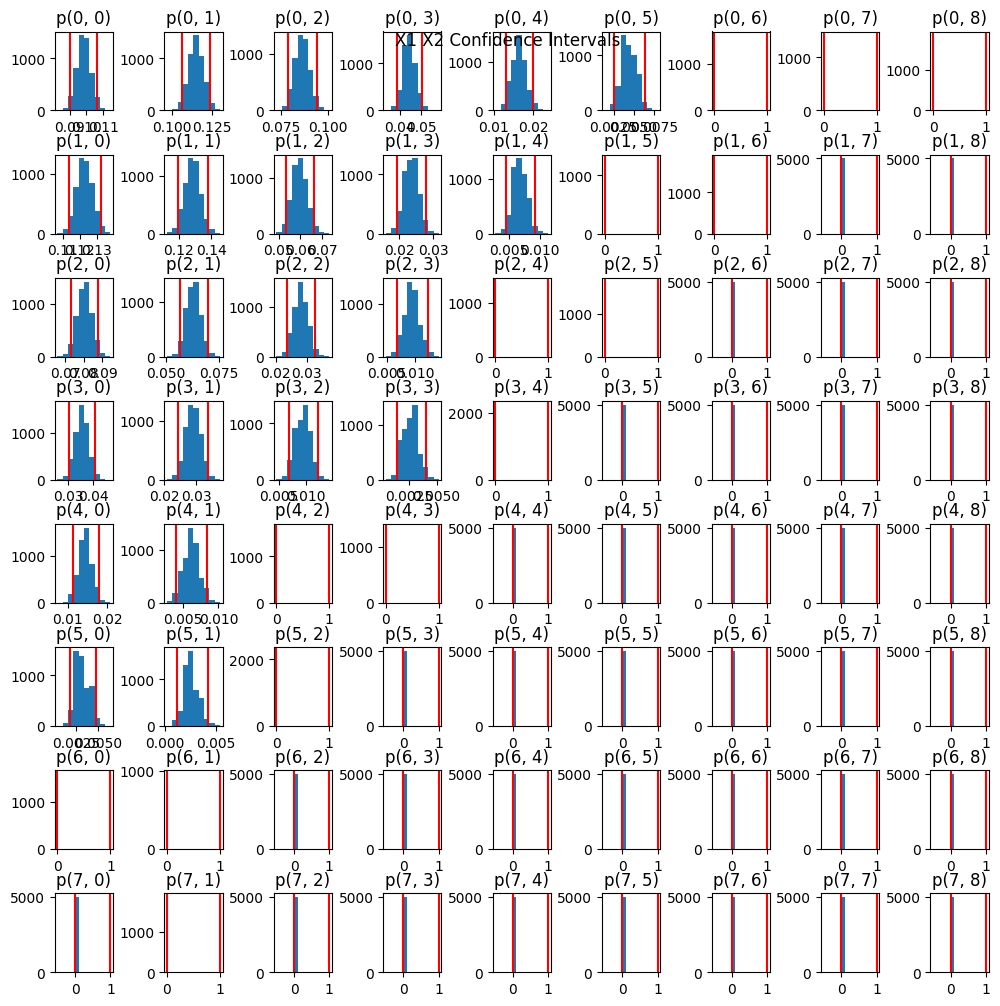

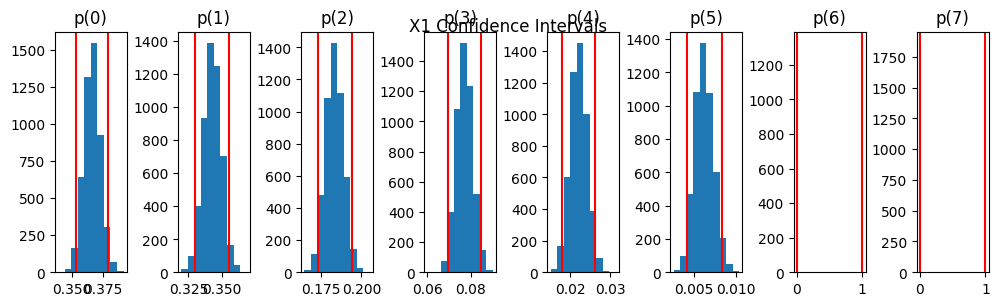

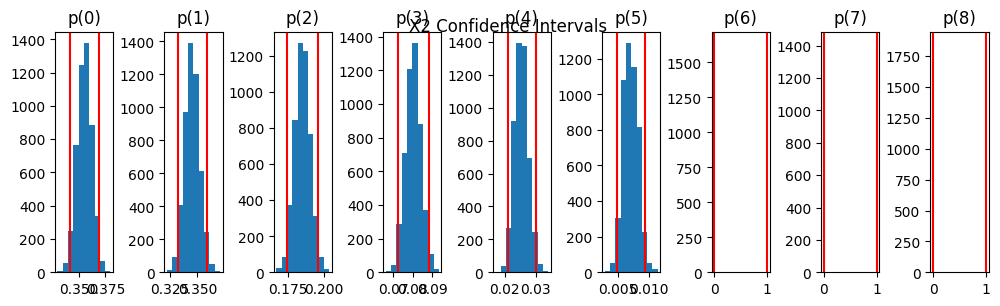

In [25]:
# bootstrap CI's
bounds = bootstrap(params_sim, 5000, 5000, thresh=10, plot=True)

In [26]:
# optimize
solution = optimization(params_opt, bounds, M=7, N=7, silent=True, test_feasible=True)

k_tx_1 in (1.1631052951431256, 3.397028564487166)
k_tx_2 in (1.024288721804821, 3.7686344046146694)
k_deg_1 in (0.2132086552961753, 2.2794639464689714)
k_deg_2 in (0.07121804079960557, 2.560214724100826)
k_reg = 1
Model is OPTIMAL


## Testing for interaction

Given simulated, or real, data from a reaction network we want to know if there is interaction between the 2 species of transcripts, or if they obey independent birth death processes i.e. $k_{deg} = 0$.

### Method 1:

Fix a parameter of the reaction network for identifiability e.g. $k_{deg_2} = 1$ and optimize for $k_{reg}$. If the resulting bounds do not contain 0 (non-zero lower bound) this suggests there is interaction in the system, up to 95% confidence of the bounds used.

### Method 2:

Assume as a null hypothesis there is no interaction, $H_{0}: k_{reg} = 0$, and so the stationary distribution factorises into 2 independent birth death stationary distributions:

$ p(x_1, x_2) = p(x_1)p(x_2) = Poi \left(\frac{k_{tx_1}}{k_{deg_1}} \right) Poi \left(\frac{k_{tx_2}}{k_{deg_2}} \right) $

Fixing 1 parameter in each of the ratios e.g. $k_{deg_1} = 1$ and $k_{deg_2} = 1 $, leaves the stationary distribution unchanged and so given only data from the stationary distribution allows identifiability of the parameters.

Fixing $k_{reg} = 0$, an infeasible solution suggests that the data is not consistent with a model of no interaction. However, a feasible solution to the optimization problem suggests there are parameter values that together with the data satisfy a model of no interaction, but does not confirm that there is no interaction.

NOTE: do not need to optimize, but simply check feasibility / infeasiblity status of problem

#### Test: data with high interaction

In [27]:
# parameter values for simulation: large regulation
params_simul = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 10
}

# optimize over regulation parameter (method 1)
params_optim_var = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "vo"
}

# fix regulation parameter to 0 (method 2)
params_optim_zero = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

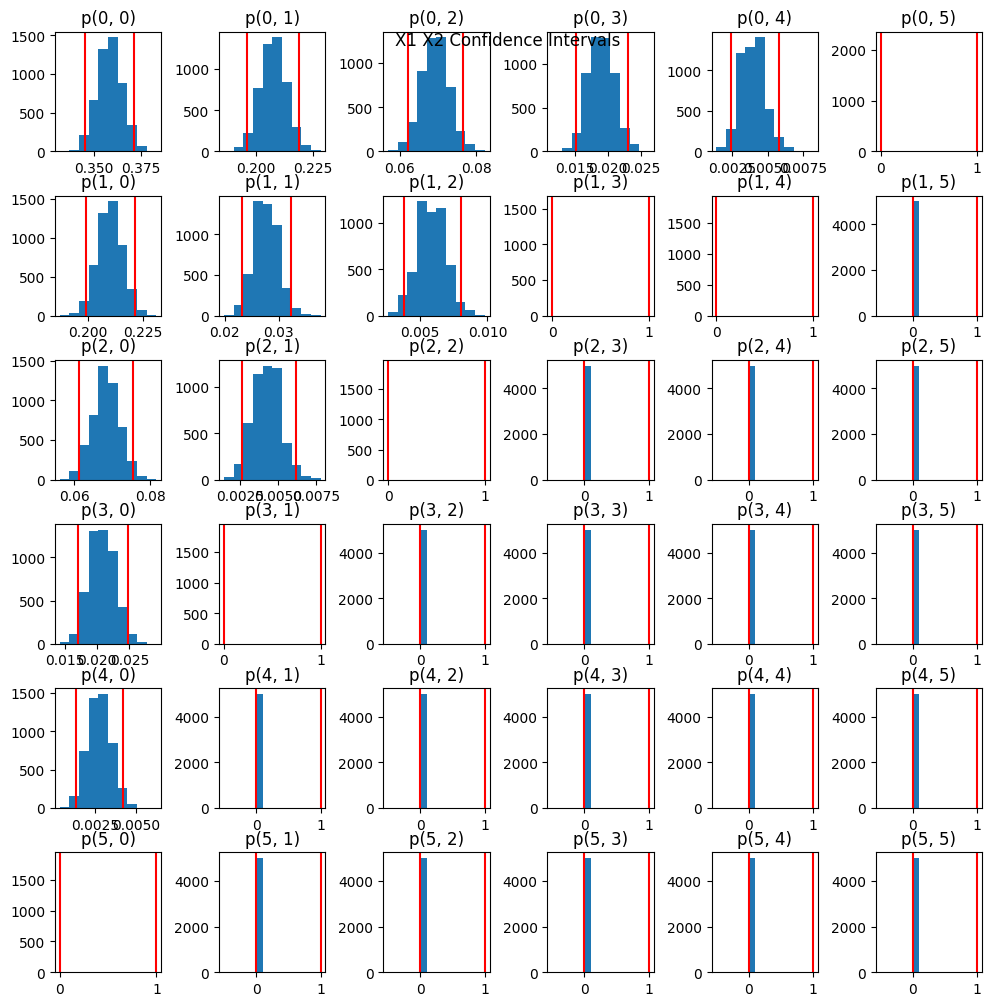

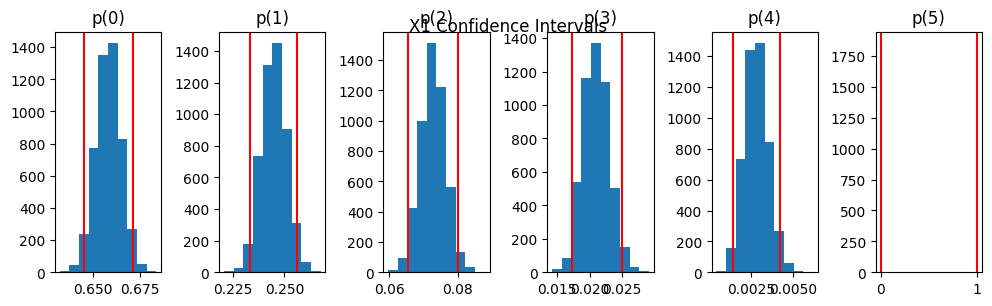

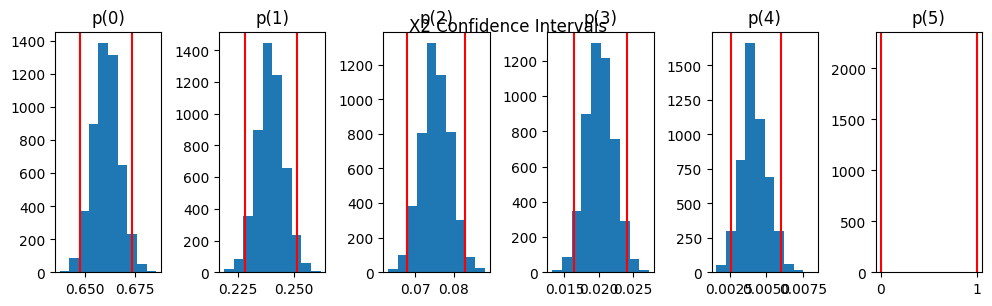

In [28]:
# simulate and bootstrap to produce CI bounds on stat. dist.
bounds_test = bootstrap(params_simul, 5000, 5000, thresh=10, plot=True)

In [29]:
# method 1: leave k_reg variable, use data with high regulation, optimize
solution_test = optimization(params_optim_var, bounds_test, M=3, N=3, K=20, silent=True)

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (3.5274243502888707, 20.0)


Bounds on $k_{reg}$ do not contain 0 which suggests there is interaction, as expected

In [30]:
# method 2: fix k_reg = 0, use data with high regulation, test feasibility
solution_test = optimization(params_optim_zero, bounds_test, M=3, N=3, K=20, silent=True, test_feasible=True)

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


Infeasible, as expected for data simulated with interaction

#### Test: data with low interaction

In [31]:
# parameter values for simulation: low regulation
params_simul = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0.1
}

# optimize over regulation parameter, fix another for identifiability (method 1)
params_optim_var = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "vo"
}

# fix regulation parameter to 0 (method 2)
params_optim_zero = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}


In [39]:
# simulate and bootstrap to produce CI bounds on stat. dist.
bounds_test = bootstrap(params_simul, 5000, 5000, thresh=10, plot=False)
bounds_test['joint'].shape

(2, 7, 7)

In [43]:
# method 1: leave k_reg variable, use data with high regulation, optimize
solution_test = optimization(params_optim_var, bounds_test, M=6, N=6, K=20, silent=True)

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (0.0, 2.1928936161229196)


In [44]:
solution_test = optimization(params_optim_var, bounds_test, M=7, N=7, K=20, silent=True)

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (0.02071029194113597, 1.7937205475068443)


Non zero lower bound, but only when a large number of bounds are used

In [45]:
# method 2: fix k_reg = 0, use data with low regulation, test feasibility
solution_test = optimization(params_optim_zero, bounds_test, M=6, N=6, K=20, silent=True, test_feasible=True)

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is OPTIMAL


In [46]:
solution_test = optimization(params_optim_zero, bounds_test, M=7, N=7, K=20, silent=True, test_feasible=True)

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


Infeasible, but again only when a large number of bounds are used

NOTE: significantly faster to just test feasibility (method 2) than optimize (method 1)

#### Test: data with no interaction

In [47]:
# parameter values for simulation: 0 regulation parameter
params_simul = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# optimize over regulation parameter, fix another for identifiability (method 1)
params_optim_var = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "vo"
}

# fix regulation parameter to 0 (method 2)
params_optim_zero = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

In [48]:
# simulate and bootstrap to produce CI bounds on stat. dist.
bounds_test = bootstrap(params_simul, 5000, 5000, thresh=10, plot=False)
bounds_test['joint'].shape

(2, 7, 7)

In [49]:
# method 1: leave k_reg variable, use data with high regulation, optimize
solution_test = optimization(params_optim_var, bounds_test, M=7, N=7, K=20, silent=True)

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (0.0, 1.3482146654703666)


Even when all bounds used the lower bound on $k_{reg}$ is still zero, so do not have evidence to suggest interaction. However, the upper bound on $k_{reg}$ is not zero so cannot conclude there is no interaction (although evidence towards)

In [50]:
# method 2: fix k_reg = 0, use data with low regulation, test feasibility
solution_test = optimization(params_optim_zero, bounds_test, M=7, N=7, K=20, silent=True, test_feasible=True)

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is OPTIMAL


Even when all bounds used the problem is still feasible, so do not have evidence to reject null hypothesis / to suggest iteraction present. BUT, cannot accept the null hypothesis, and cannot conclude there is no interaction (although evidence towards).

## 2 Step method

Following method 2 and assuming a hypothesis of no interaction we have that each transcript, $X_{1}$ and $X_{2}$, follows an independent birth death reaction. Taking the $x_{1}$ and $x_{2}$ counts from the sample we can optimize 2 birth death processes to bound $k_{tx_1}$ and $k_{tx_2}$, and use the resulting bounds as additional constraints in optimization of the full model (where we fix $k_{reg}=0$ as assumed).

NOTE: in the optimizations it is important to fix the parameters $k_{deg_1}$ and $k_{deg_2}$ to the same values (to ensure identifiability, with the assumption of independence allowing fixing of both)

In [127]:
def optimization_single(params, bounds, tr=1, M=None, K=10, silent=True, print_solution=True, test_feasible=False):
    '''
    Non-linear optimization to produce bounds on parameters of interest

    params: dictionary of reaction rate constants
            fixed value, "v" for variable, "vo" for variable to optimize
    bounds: 2 x N array of confidence interval bounds on stat. dist. of system
    silent: toggle printing of optimization status
    '''

    # create model
    md = gp.Model('birth-death')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set 5 minute time limit
    md.Params.TimeLimit = 300

    # size
    if not M:
        M = bounds.shape[1]

    # variables

    # stationary distribution
    p = md.addMVar(shape=M, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    rate_names = [f'k_tx_{tr}', f'k_deg_{tr}']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # set fixed values
    for name, value in params.items():
        if value == "v" or value == "vo":
            pass
        else:
            md.addConstr(rates[name] == value)

    # stationary distribution bounds
    for x in range(M):
        md.addConstr(p[x] >= bounds[f'x{tr}'][0, x], name=f"lb {x}")
        md.addConstr(p[x] <= bounds[f'x{tr}'][1, x], name=f"ub {x}")

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # stationary Qp=0 equations for all relevant variables
    for x in range(M - 1):
        if x == 0:
            x_zero = 0
        else:
            x_zero = 1

        md.addConstr(
            # remove terms when x = 0 since not in equation
            # so multiply by toggle
            rates[f'k_tx_{tr}'] * x_zero * p[x - 1] + \
            rates[f'k_deg_{tr}'] * (x + 1) * p[x + 1] - \
            (rates[f'k_tx_{tr}'] + \
             rates[f'k_deg_{tr}'] * x) * p[x] == 0,
            name=f"Equation {x}"
            )

    # solution dict
    solution = {}

    # optimize
    for name, value in params.items():

        # variable
        if value == "vo":

            # minimize
            md.setObjective(rates[name], GRB.MINIMIZE)
            try:
                md.optimize()
                min_val = md.ObjVal
            except:
                min_val = None

            # maximize
            md.setObjective(rates[name], GRB.MAXIMIZE)
            try:
                md.optimize()
                max_val = md.ObjVal
            except:
                max_val = None

            # store
            solution[name] = [min_val, max_val]
    
        # constant
        else:
            solution[name] = value

    if test_feasible:
        # if testing feasibility simply optimize 0 to check
        md.setObjective(0, GRB.MINIMIZE)

        # set parameter (prevents 'infeasible or unbounded' ambiguity)
        md.Params.DualReductions = 0
        try:
            md.optimize()
            status_code = md.status
        except:
            status_code = md.status

        # decode status
        status_codes = {1: 'LOADED',
                        2: 'OPTIMAL',
                        3: 'INFEASIBLE',
                        4: 'INF_OR_UNBD',
                        5: 'UNBOUNDED',
                        6: 'CUTOFF',
                        7: 'ITERATION_LIMIT',
                        8: 'NODE_LIMIT',
                        9: 'TIME_LIMIT',
                        10: 'SOLUTION_LIMIT',
                        11: 'INTERRUPTED',
                        12: 'NUMERIC',
                        13: 'SUBOPTIMAL',
                        14: 'INPROGRESS',
                        15: 'USER_OBJ_LIMIT'}

        # store result
        solution['feasible'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == 'feasible':
                print(f"Model is {val}")
            elif type(val) == list:
                print(f"{key} in ({val[0]}, {val[1]})")
            elif val == "v":
                print(f"{key} variable, not optimized")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

In [128]:
# parameter values for simulation: 0 regulation parameter
# so X1 and X2 follow independent birth deaths
params_simul = {
    'k_tx_1': 2,
    'k_tx_2': 3,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# optimize x1 BD
params_optim_x1 = {
    'k_tx_1': "vo",
    'k_deg_1': 1
}

# optimize x2 BD
params_optim_x2 = {
    'k_tx_2': "vo",
    'k_deg_2': 1
}

In [129]:
# simulate and bootstrap to produce CI bounds on stat. dist.
bounds_test = bootstrap(params_simul, 5000, 5000, thresh=10, plot=False)
bounds_test['joint'].shape

(2, 10, 12)

In [130]:
# optimize birth death using x1 bounds
solution_x1 = optimization_single(params_optim_x1, bounds_test, tr=1, M=3, test_feasible=True)

k_tx_1 in (1.8820224785127084, 2.0611940298507476)
k_deg_1 = 1
Model is OPTIMAL


In [131]:
# optimize birth death using x1 bounds
solution_x2 = optimization_single(params_optim_x2, bounds_test, tr=2, M=3, test_feasible=True)

k_tx_2 in (2.6418595318736693, 3.1402996423777267)
k_deg_2 = 1
Model is OPTIMAL


We see that each optimization produces bounds about the true value of the parameters, as expected for a model with $k_{reg} = 0$ which is the same as 2 independent birth death processes.

#### Test: data with high interaction

Is there improvement in the number of CI bounds needed to suggest interaction is present

In [134]:
# parameter values for simulation: large regulation
params_simul = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 10
}

# full optimization (method 2)
params_optim_zero = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# x1 optimization
params_optim_x1 = {
    'k_tx_1': "vo",
    'k_deg_1': 1
}

# x2 optimization
params_optim_x2 = {
    'k_tx_2': "vo",
    'k_deg_2': 1
}

In [135]:
# simulate and bootstrap to produce CI bounds on stat. dist.
bounds_test = bootstrap(params_simul, 5000, 5000, thresh=10, plot=False)
bounds_test['joint'].shape

(2, 6, 5)

In [136]:
# optimize birth death using x1 bounds
solution_x1 = optimization_single(params_optim_x1, bounds_test, tr=1, M=2, test_feasible=True)

k_tx_1 in (0.3320621932796837, 0.3812137846904544)
k_deg_1 = 1
Model is OPTIMAL


In [137]:
# optimize birth death using x2 bounds
solution_x2 = optimization_single(params_optim_x2, bounds_test, tr=2, M=2, test_feasible=True)

k_tx_2 in (0.34118340206956177, 0.3927696078431372)
k_deg_2 = 1
Model is OPTIMAL


Using data with high interaction, the assumption that the $x_{1}$ and $x_{2}$ counts follow independent birth deaths is false, and leads to the individual optimizations producing parameter bounds that do not contain the true value AND become infeasible when more CI bounds are used.

This is interesting, as it suggests that simply by assuming independent behaviour of transcripts and optimizing over EACH we can already conclude the model does not fit the data and suggest there is interaction between the transcripts.

In [143]:
# method 2: fix k_reg = 0, use data with low regulation, test feasibility
solution_test = optimization(params_optim_zero, bounds_test, M=3, N=3, K=20, silent=True, test_feasible=True)

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


In [141]:
# collect solution bounds on parameters
param_bounds = {
    'k_tx_1': solution_x1['k_tx_1'],
    'k_tx_2': solution_x2['k_tx_2']
}

In [142]:
# add in solution bounds from x1 and x2 counts
solution_test = optimization(params_optim_zero, bounds_test, M=2, N=2, K=20, silent=True, test_feasible=True, param_bounds=param_bounds)

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


Testing feasibility of the full model we see that including bounds from the individual optimizations can reduce the number of bounds needed to reach an infeasible optimization (and so suggest the prescence of interaction in the data).

#### Test: data with low interaction

Hopefully the additional constraints on the parameters will help in this difficult setting

In [159]:
# parameter values for simulation: low regulation
params_simul = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0.1
}

# full optimization (method 2)
params_optim_zero = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# x1 optimization
params_optim_x1 = {
    'k_tx_1': "vo",
    'k_deg_1': 1
}

# x2 optimization
params_optim_x2 = {
    'k_tx_2': "vo",
    'k_deg_2': 1
}

In [160]:
# simulate and bootstrap to produce CI bounds on stat. dist.
bounds_test = bootstrap(params_simul, 5000, 5000, thresh=10, plot=False)
bounds_test['joint'].shape

(2, 7, 7)

In [161]:
# optimize birth death using x1 bounds
solution_x1 = optimization_single(params_optim_x1, bounds_test, tr=1, M=7, test_feasible=True)

k_tx_1 in (0.8924361559533505, 0.960473438262493)
k_deg_1 = 1
Model is OPTIMAL


In [162]:
# optimize birth death using x2 bounds
solution_x2 = optimization_single(params_optim_x2, bounds_test, tr=2, M=7, test_feasible=True)

k_tx_2 in (0.8701620229105007, 0.9118481746839658)
k_deg_2 = 1
Model is OPTIMAL


Again see the bounds do not contain true value (expected, as based on false assumption)

In [166]:
# method 2: fix k_reg = 0, use data with low regulation, test feasibility
solution_test = optimization(params_optim_zero, bounds_test, M=6, N=6, K=20, silent=True, test_feasible=True)

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


In [167]:
# collect solution bounds on parameters
param_bounds = {
    'k_tx_1': solution_x1['k_tx_1'],
    'k_tx_2': solution_x2['k_tx_2']
}

In [169]:
# add in solution bounds from x1 and x2 counts
solution_test = optimization(params_optim_zero, bounds_test, M=6, N=6, K=20, silent=True, test_feasible=True, param_bounds=param_bounds)

k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


Adding parameter bounds based on individual optimizations does not seem to reduce the number of bounds needed to reach an infeasible model, but as seen with the high interaction case may do so, and there is little downside to adding the constraints, especially since the individual bounds can provide insight.

# Capture efficiency

Now assume that observations of the transcripts $X_{1}$ and $X_{2}$ are affected by 'capture efficiency', where each transcript has a probability $\beta$ of being 'captured' by the single-cell-sequencing process. Denoting the 'original' (true) counts with 'OG' and the 'observed' (affected by capture eff.) counts with 'OB', we have that:

$$ X_{1}^{OB} \vert X_{1}^{OG} , \beta \sim \text{Binomial}(X_{1}^{OG}, \beta) $$

$$ X_{2}^{OB} \vert X_{2}^{OG} , \beta \sim \text{Binomial}(X_{2}^{OG}, \beta) $$


The model is defined in terms of the original counts $X_{1}^{OG}$ and $X_{2}^{OG}$ and their distribution, but we compute bounds on the observed counts $X_{1}^{OB}$ and $X_{2}^{OB}$. To use the data in the optimization problem we need to adjust the bound constraints from the simple:

$$ \widehat{p(x_{1}, x_{2})_{L}} \le p(x_{1}, x_{2}) \le \widehat{p(x_{1}, x_{2})_{U}} $$

To the more complicated:

$$ \widehat{p(x_{1}^{OB}, x_{2}^{OB})_{L}} - \text{truncation error bound} \le \frac{1}{n} \sum_{j=1}^{n} \sum_{x_{1}^{OG} = 0}^{M^{OG} - 1} \sum_{x_{2}^{OG} = 0}^{N^{OG} - 1} B(x_{1}^{OB}, x_{2}^{OB}, x_{1}^{OG}, x_{2}^{OG}, \beta_{j}) p(x_{1}^{OG}, x_{2}^{OG}) \le \widehat{p(x_{1}^{OB}, x_{2}^{OB})_{U}} $$

where the truncation error bound is given by:

$$
\frac{3 \widehat{\mathbb{E}\left[X_{1}^{OB} X_{2}^{OB} \right]}_{U}}{M^{OG} N^{OG} \mathbb{E}\left[\beta^2 \right]}
$$

Using bootstrap confidence interval for an upper (U) bound on $\mathbb{E}\left[X_{1}^{OB} X_{2}^{OB} \right]$

## Simulation

We modify the simulation code to apply capture efficiency

In [6]:
def simulation_B(params, n, beta, tmax, ts, plot=False, initial_state=(0, 0)):
    '''
    Simulate a sample path of the birth death regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    beta: capture efficiency, list of length n (per cell) or single value
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2 = path[-1][0], path[-1][1]

        # transition rates
        q_tx_1 = params['k_tx_1']
        q_tx_2 = params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_tx_1 + q_tx_2 + q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5]
        prob = [
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1 + 1, x2))
            case 2:
                path.append((x1, x2 + 1))
            case 3:
                path.append((x1 - 1, x2))
            case 4:
                path.append((x1, x2 - 1))
            case 5:
                path.append((x1 - 1, x2 - 1))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)

    # convert to integers
    x1_samples = [int(x1) for x1 in x1_samples]
    x2_samples = [int(x2) for x2 in x2_samples]

    # apply capture efficiency: for each count, draw from Binomial(count, beta)
    x1_samples_beta = np.random.binomial(x1_samples, beta).tolist()
    x2_samples_beta = np.random.binomial(x2_samples, beta).tolist()

    # re-combine to pairs of samples
    samples = list(zip(x1_samples, x2_samples))
    samples_beta = list(zip(x1_samples_beta, x2_samples_beta))

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("# molcules")
        plt.legend()
        plt.show()

    # collect all sample paths: original and observed
    data = {
        'x1_OG': x1_samples,
        'x2_OG': x2_samples,
        'OG': samples,
        'x1_OB': x1_samples_beta,
        'x2_OB': x2_samples_beta,
        'OB': samples_beta
    }

    return data

## Bootstrap

We modify the bootstrap code to compute these confidence intervals, using the same bootstrap samples as are used to bound the observed probability distribution:

In [10]:
def bootstrap_B(params, n, B, beta, tmax=100, ts=10, thresh=1, plot=False, printing=False, initial_state=(0, 0)):
    '''
    Compute bootstrap confidence intervals on stationary distribution by 
    simulating sample path and computing empirical distribution over 
    several bootstrap samples

    params: dict of reaction rate constants
    n: number of samples from stationary distribution
    B: number of bootstrap resamples
    beta: capture efficiency, list of length n (per cell) or single value
    tmax: burn-in time for sampling
    ts: time between samples
    thresh: minimum occurnces of a state in the original sample to use the CI
        otherwise replaced by [0, 1] bounds
    plot: toggle plotting CI's
    printing: toggle printing CI's
    initial_state: starting point of sampling
    '''
    # simulate n samples from stationary distribution
    samples = simulation_B(params, n, beta, tmax, ts, plot=False, initial_state=initial_state)

    '''E[X1X2] moment CI bounds'''
    # compute product of counts
    product_samples = np.array(samples['x1_OB']) * np.array(samples['x2_OB'])

    # B bootstrap samples as a B x n array
    product_bootstrap = rng.choice(product_samples, size=(B, n))

    # take mean over rows to compute E[X1X2] moment
    product_moment = product_bootstrap.mean(axis=1)

    # compute 2.5% and 97.5% quantiles for CI bounds
    product_moment_bounds = np.quantile(product_moment, [0.025, 0.975], axis=0)

    '''
    boot_test = rng.choice(samples['OG'], size=(B,n))
    prod = lambda x: x[0] * x[1]
    prod_array = np.apply_along_axis(prod, 2, boot_test)
    OG_prod_moment = prod_array.mean(axis=1)
    OG_prod_moment_bounds = np.quantile(OG_prod_moment, [0.025, 0.975], axis=0)

    # B bootstrap samples for each as B x n array
    x1_bootstrap = rng.choice(samples['x1_OB'], size=(B, n))
    x2_bootstrap = rng.choice(samples['x2_OB'], size=(B, n))

    # average over rows to compute 1st and 2nd moment estimates
    x1_1st_moment = x1_bootstrap.mean(axis=1)
    x1_2nd_moment = (x1_bootstrap**2).mean(axis=1)
    x2_1st_moment = x2_bootstrap.mean(axis=1)
    x2_2nd_moment = (x2_bootstrap**2).mean(axis=1)

    # compute 2.5% and 97.5% quantiles for each moment
    x1_1st_moment_bounds = np.quantile(x1_1st_moment, [0.025, 0.975], axis=0)
    x1_2nd_moment_bounds = np.quantile(x1_2nd_moment, [0.025, 0.975], axis=0)
    x2_1st_moment_bounds = np.quantile(x2_1st_moment, [0.025, 0.975], axis=0)
    x2_2nd_moment_bounds = np.quantile(x2_2nd_moment, [0.025, 0.975], axis=0)
    '''

    # compute maximum x1 and x2 values
    M = np.max(samples['x1_OB'])
    N = np.max(samples['x2_OB'])

    # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
    integer_samples = [sample[1] + (N + 1)*sample[0] for sample in samples['OB']]

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # B bootstrap samples as B x n array
    bootstrap = rng.choice(integer_samples, size=(B, n))

    # offset row i by (D + 1)i
    bootstrap_offset = bootstrap + np.arange(B)[:, None]*(D + 1)

    # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
    counts = np.bincount(bootstrap_offset.ravel(), minlength=B*(D + 1)).reshape(-1, M + 1, N + 1)

    # counts to probability
    counts = counts / n

    # sum over columns / rows to give counts of each x1 / x2 state
    x1_counts = counts.sum(axis=2)
    x2_counts = counts.sum(axis=1)

    # compute 2.5% and 97.5% quantiles for each p(x1, x2), p(x1) and p(x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_samples, minlength=D + 1).reshape(M + 1, N + 1)

    # sum over columns / rows to give counts per x1 / x2 state
    x1_sample_counts = sample_counts.sum(axis=1)
    x2_sample_counts = sample_counts.sum(axis=0)

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            if sample_counts[x1, x2] < thresh:
                bounds[:, x1, x2] = [0.0, 1.0]

    for x1 in range(M + 1):
        if x1_sample_counts[x1] < thresh:
            x1_bounds[:, x1] = [0.0, 1.0]

    for x2 in range(N + 1):
        if x2_sample_counts[x2] < thresh:
            x2_bounds[:, x2] = [0.0, 1.0]

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                axs[x1, x2].hist(counts[:, x1, x2])
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color="red")
                axs[x1, x2].axvline(bounds[1, x1, x2], color="red")

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M + 1, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M + 1):
            axs[x1].hist(x1_counts[:, x1])
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color="red")
            axs[x1].axvline(x1_bounds[1, x1], color="red")

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N + 1, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N + 1):
            axs[x2].hist(x2_counts[:, x2])
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color="red")
            axs[x2].axvline(x2_bounds[1, x2], color="red")

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    results =  {
        'joint': bounds,
        'x1': x1_bounds,
        'x2': x2_bounds,
        'product_moment_bounds': product_moment_bounds
    }

    return results

In [8]:
params_boot_test = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

In [188]:
bounds = bootstrap(params_boot_test, 5000, 5000, thresh=10, plot=False)

In [11]:
bounds_B = bootstrap_B(params_boot_test, 5000, 5000, 0.5, thresh=10, plot=False)

Adds only a small amount of time to the bootstrap process (as seen above)

In [13]:
# example of CI bounds
bounds_B['product_moment_bounds']

array([0.0724, 0.092 ])

## Optimization

We modify the optimization code, replacing the distribution bound constraints by the more complicated version above to account for the capture efficiency

In [40]:
def B(x1_OB, x2_OB, x1_OG, x2_OG, beta):
    '''Compute (1 / n) sum j = 1 to n of P(X1_OB, X2_OB | X1_OG, X2_OG, Beta_j): product of binomials.'''

    val = 0.0

    # compute binomial probability
    if (x1_OB <= x1_OG) and (x2_OB <= x2_OG):

        bin_coef_x1 = scipy.special.comb(x1_OG, x1_OB)
        bin_coef_x2 = scipy.special.comb(x2_OG, x2_OB)

        for beta_j in beta:

            p1 = beta_j**x1_OB * (1 - beta_j)**(x1_OG - x1_OB)
            p2 = beta_j**x2_OB * (1 - beta_j)**(x2_OG - x2_OB)
            val += p1 * p2

        n = beta.shape[0]
        val = float(bin_coef_x1 * bin_coef_x2 * val / n)

        return val
    
    # asssume we cannot observe more counts than are present originally
    else:
        return val

In [45]:
def optimization_B(params, bounds, beta, truncation=None, K=10, silent=True, frechet=True,
                   print_solution=True, test_feasible=False, param_bounds=None):
    '''
    Non-linear optimization to produce bounds on parameters of interest

    params: dictionary of reaction rate constants
            fixed value, "v" for variable, "vo" for variable to optimize
    bounds: 2 x M x N array of confidence interval bounds on stat. dist. of system
    beta: capture efficiency
    truncation: size of observed and original bounds used
    K: fixed upper bound on reaction rate constants
    silent: toggle printing of optimization status
    frechet: toggle for frechet bounds
    print_solution: toggle for printing optimization solution
    test_feasible: additional test for the feasibility of the optimization
    param_bounds: additional bounds on reaction rate constants
    '''

    # create model
    md = gp.Model('birth-death-regulation-capture-efficiency')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set 5 minute time limit
    md.Params.TimeLimit = 300

    # capture efficiency 2nd moment
    beta_2nd_moment = np.mean(beta ** 2)
    
    # state truncations
    if truncation == None:

        # default to using 1 less bound than observed
        M_OB = bounds['joint'].shape[1] - 1
        N_OB = bounds['joint'].shape[2] - 1

        # default to using observed maximum, scaled by mean capture efficiency
        M_OG = int(M_OB / np.mean(beta))
        N_OG = int(N_OB / np.mean(beta))

        print(M_OB, N_OB, M_OG, N_OG)

    else:

        # if provided, extract from dict
        M_OB = truncation['M_OB']
        N_OB = truncation['N_OB']
        M_OG = truncation['M_OG']
        N_OG = truncation['N_OG']

    # compute upper bound on truncation error
    t_bound = (3 * bounds['product_moment_bounds'][1]) / (M_OG * N_OG * beta_2nd_moment)

    print(f"Bound on trunaction error: {t_bound}")

    '''
    # compute uppper bound on truncation error
    term_1 = 3 / (M_OG * N_OG)
    term_2 = (bounds['x1_2nd_moment_bounds'][1] - \
              bounds['x1_1st_moment_bounds'][0]*beta_mean + \
              bounds['x1_1st_moment_bounds'][1]*beta_2nd_moment) / beta_2nd_moment
    term_3 = (bounds['x2_2nd_moment_bounds'][1] - \
              bounds['x2_1st_moment_bounds'][0]*beta_mean + \
              bounds['x2_1st_moment_bounds'][1]*beta_2nd_moment) / beta_2nd_moment

    t_bound = term_1 * np.sqrt(term_2 * term_3)

    t_bound_test = term_1 * bounds['OG_prod_moment_bounds'][1]

    term_4 = bounds_B['x1_1st_moment_bounds'][1] / (M_OG * beta_mean)
    term_5 = bounds_B['x2_1st_moment_bounds'][1] / (N_OG * beta_mean)

    t_bound_new = term_4 + term_5

    print(f"Bound on truncation error: \n{t_bound} \n")

    print(f"Test bound on truncation error: \n{t_bound_test} \n")

    print(f"New bound on truncation error: \n{t_bound_new} \n")
    '''

    # variables

    # stationary distribution: original counts
    p = md.addMVar(shape=(M_OG, N_OG), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # set fixed values
    for name, value in params.items():
        if value == "v" or value == "vo":
            pass
        else:
            md.addConstr(rates[name] == value)

    # add any bounds given
    try:
        for name, value in param_bounds.items():
            md.addConstr(rates[name] <= value[1])
            md.addConstr(rates[name] >= value[0])
    except AttributeError:
        pass

    # stationary distribution bounds: for each observed count
    for x1_OB in range(M_OB):
        for x2_OB in range(N_OB):

            sum_expr = gp.quicksum([B(x1_OB, x2_OB, x1_OG, x2_OG, beta) * p[x1_OG, x2_OG] for x1_OG in range(M_OG) for x2_OG in range(N_OG)])

            md.addConstr(sum_expr >= bounds['joint'][0, x1_OB, x2_OB] - t_bound, name=f"B lb {x1_OB}, {x2_OB}")
            md.addConstr(sum_expr <= bounds['joint'][1, x1_OB, x2_OB], name=f"B ub {x1_OB}, {x2_OB}")

    '''
    for x1 in range(M):
        for x2 in range(N):
            md.addConstr(p[x1, x2] >= bounds['joint'][0, x1, x2], name=f"lb {x1}, {x2}")
            md.addConstr(p[x1, x2] <= bounds['joint'][1, x1, x2], name=f"ub {x1}, {x2}")

            # additional frechet bounds
            if frechet:
                md.addConstr(p[x1, x2] >= bounds['x1'][0, x1] + bounds['x2'][0, x2] - 1, name=f"Frechet lb {x1}, {x2}")
                md.addConstr(p[x1, x2] <= bounds['x1'][1, x1], name=f"Frechet ub x1 {x1}, {x2}")
                md.addConstr(p[x1, x2] <= bounds['x2'][1, x2], name=f"Frechet ub x2 {x2}, {x2}")
    '''

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # stationary Qp=0 equations for all relevant variables
    for x1_OG in range(M_OG - 1):
        for x2_OG in range(N_OG - 1):
            if x1_OG == 0:
                x1_zero = 0
            else:
                x1_zero = 1
            if x2_OG == 0:
                x2_zero = 0
            else:
                x2_zero = 1

            md.addConstr(
                # remove terms when x1 or x2 = 0 since not in equation
                # so multiply by toggle
                rates['k_tx_1'] * x1_zero * p[x1_OG - 1, x2_OG] + \
                rates['k_tx_2'] * x2_zero * p[x1_OG, x2_OG - 1] + \
                rates['k_deg_1'] * (x1_OG + 1) * p[x1_OG + 1, x2_OG] + \
                rates['k_deg_2'] * (x2_OG + 1) * p[x1_OG, x2_OG + 1] + \
                rates['k_reg'] * (x1_OG + 1) * (x2_OG + 1) * p[x1_OG + 1, x2_OG + 1] - \
                (rates['k_tx_1'] + rates['k_tx_2'] + \
                 rates['k_deg_1'] * x1_OG + rates['k_deg_2'] * x2_OG + \
                 rates['k_reg'] * x1_OG * x2_OG) * p[x1_OG, x2_OG] == 0,
                name=f"Equation {x1_OG}, {x2_OG}"
                )

    # solution dict
    solution = {}

    # optimize
    for name, value in params.items():

        # variable
        if value == "vo":

            # minimize
            md.setObjective(rates[name], GRB.MINIMIZE)
            try:
                md.optimize()
                min_val = md.ObjVal
            except:
                min_val = None

            # maximize
            md.setObjective(rates[name], GRB.MAXIMIZE)
            try:
                md.optimize()
                max_val = md.ObjVal
            except:
                max_val = None

            # store
            solution[name] = [min_val, max_val]
    
        # constant
        else:
            solution[name] = value

    if test_feasible:
        # if testing feasibility simply optimize 0 to check
        md.setObjective(0, GRB.MINIMIZE)

        # set parameter (prevents 'infeasible or unbounded' ambiguity)
        md.Params.DualReductions = 0
        try:
            md.optimize()
            status_code = md.status
        except:
            status_code = md.status

        # decode status
        status_codes = {1: 'LOADED',
                        2: 'OPTIMAL',
                        3: 'INFEASIBLE',
                        4: 'INF_OR_UNBD',
                        5: 'UNBOUNDED',
                        6: 'CUTOFF',
                        7: 'ITERATION_LIMIT',
                        8: 'NODE_LIMIT',
                        9: 'TIME_LIMIT',
                        10: 'SOLUTION_LIMIT',
                        11: 'INTERRUPTED',
                        12: 'NUMERIC',
                        13: 'SUBOPTIMAL',
                        14: 'INPROGRESS',
                        15: 'USER_OBJ_LIMIT'}

        # store result
        solution['feasible'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == 'feasible':
                print(f"Model is {val}")
            elif type(val) == list:
                print(f"{key} in ({val[0]}, {val[1]})")
            elif val == "v":
                print(f"{key} variable, not optimized")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

## Example

In [49]:
# set simulation parameters
params_simul_B = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

# set capture efficiency
n = 5000
beta = np.array([0.9 for j in range(n)])

# choose variable / variables to optimize over / fixed parameters for optimization
params_optim_B = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "vo"
}


In [50]:
# simulate and bootstrap data
bounds_B = bootstrap_B(params_simul_B, 5000, 5000, beta, thresh=10, plot=False)
bounds_B['joint'].shape

(2, 6, 6)

In [51]:
truncation = {
    'M_OB': 5,
    'N_OB': 6,
    'M_OG': 10,
    'N_OG': 12
}

In [52]:
# optimize
solution_B = optimization_B(params_optim_B, bounds_B, beta, truncation=None, K=10, silent=False, frechet=True,
                   print_solution=True, test_feasible=False, param_bounds=None)

Set parameter TimeLimit to value 300
5 5 5 5
Bound on trunaction error: 0.04305185185185184
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 52 rows, 30 columns and 476 nonzeros
Model fingerprint: 0x8d48a03c
Model has 16 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-08, 1e+00]
  QMatrix range    [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [4e-03, 1e+00]
Presolve removed 36 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 30 rows and 1 columns
Presolve time: 0.00s
Presolved: 294 rows, 93 columns, 1003 nonzeros
Presolved model has 64 bilinear constraint(s)
Variable types

In [316]:
solution_B['model'].write('model-ce-new.lp')

In [317]:
solution_B['model'].computeIIS()
solution_B['model'].write("model-ce-new.ilp")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0        61         -         0       106         -           0s
        2         2         2        46        46        46           0s

IIS computed: 2 constraints, 46 bounds
IIS runtime: 0.07 seconds (0.00 work units)


### Testing further

In [184]:
# set simulation parameters
params_simul_B = {
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0.75
}

# set capture efficiency
n = 5000
beta = np.array([0.5 for j in range(n)])

# choose variable / variables to optimize over / fixed parameters for optimization
params_optim_B = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "vo"
}


In [185]:
# simulate and bootstrap data
bounds_B = bootstrap_B(params_simul_B, 5000, 5000, beta, thresh=10, plot=False)
bounds_B['joint'].shape

(2, 6, 7)

In [186]:
# optimize
solution_B = optimization_B(params_optim_B, bounds_B, beta, truncation=None, K=10, silent=False, frechet=True,
                   print_solution=True, test_feasible=False, param_bounds=None)

Set parameter TimeLimit to value 300
5 6 10 12
Bound on truncation error: 
1.533428647720526e-05 

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 62 rows, 125 columns and 3691 nonzeros
Model fingerprint: 0xf84d02af
Model has 99 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-03, 1e+03]
  QMatrix range    [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e-05, 1e+00]
Presolve removed 31 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 31 rows and 1 columns
Presolve time: 0.01s
Presolved: 1714 rows, 520 columns, 6419 nonzeros
Presolved model has 396 bilinear constraint(s)
Va